In [2]:
import time
import collections
import pickle
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sliding_window import sliding_window
from cluster_eval import greedy_relabel
from cluster_eval import brute_relabel
from cluster_eval import print_results
from cluster_eval import relabel_list

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 24

# Hardcoded step of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_STEP = 12

In [7]:
def load_dataset(filename):

    f = open(filename, 'rb')
    data = pickle.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: train {0}, test {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('oppChallenge_locomotion.data')

def remove_class(X_train, y_train, X_test, y_test, class_n):
    uy_train = y_train[y_train != class_n]
    uX_train = X_train[y_train != class_n]
    uy_test = y_test[y_test != class_n]
    uX_test = X_test[y_test != class_n]
    
    classes = set(y_train)
    
    for x in range(class_n + 1, len(classes)):
        uy_train[uy_train == x] = x - 1
        uy_test[uy_test == x] = x - 1
        
    return uX_train, uy_train, uX_test, uy_test

# RKN^, RKN_, BACK, HIP, R-SHOE, L-SHOE
# 53 Features
#features_delete = np.arange(6, 15)
#features_delete = np.concatenate([features_delete, np.arange(21, 36)])
#features_delete = np.concatenate([features_delete, np.arange(45, 81)])

# 60 Features
#features_delete = np.arange(0, 6)
#features_delete = np.concatenate([features_delete, np.arange(15, 21)])
#features_delete = np.concatenate([features_delete, np.arange(36, 45)])
#features_delete = np.concatenate([features_delete, np.arange(81, 113)])

# 9 Features (BACK - Phone)
#features_delete = np.arange(0, 36)
#features_delete = np.concatenate([features_delete, np.arange(45, 113)])

# 9 Features (RUA - Phone on Shoulder)
#features_delete = np.arange(0, 45)
#features_delete = np.concatenate([features_delete, np.arange(54, 113)])

# 9 Features (RLA - Wrist Watch)
#features_delete = np.arange(0, 54)
#features_delete = np.concatenate([features_delete, np.arange(63, 113)])

#X_train = np.delete(X_train, features_delete, 1)
#X_test = np.delete(X_test, features_delete, 1)

classes = ["Null", "Stand", "Walk" ,"Sit", "Lie"]

# 0 - null | 1 - stand | 2 - walk | 3 - sit | 4 - lie

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 0) # remove null
#classes.remove("Null")

# 0 - stand | 1 - walk | 2 - sit | 3 - lie

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 1) # remove walking
#classes.remove("Walk")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 3) # remove walking
#classes.remove("Lie")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 2) # remove walking
#classes.remove("Sit")

print(X_train.shape)
print(X_test.shape)

unique, counts = np.unique(y_train, return_counts=True)
label_dict = dict(zip(unique, counts))
print(label_dict)

Loading data...
 ..from file oppChallenge_locomotion.data
 ..reading instances: train (557963, 113), test (118750, 113)
(557963, 113)
(118750, 113)
{0: 92295, 1: 231751, 2: 130506, 3: 88883, 4: 14528}


In [8]:
def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = sliding_window(data_x,(ws,data_x.shape[1]),(ss,1))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# Sensor data is segmented using a sliding window mechanism

X_train, y_train = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
X_test, y_test = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)

print(" ..after sliding window (testing): inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

print(X_train.shape)
print(X_test.shape)

 ..after sliding window (testing): inputs (9894, 24, 113), targets (9894,)
(46495, 24, 113)
(9894, 24, 113)


Class Label: 1


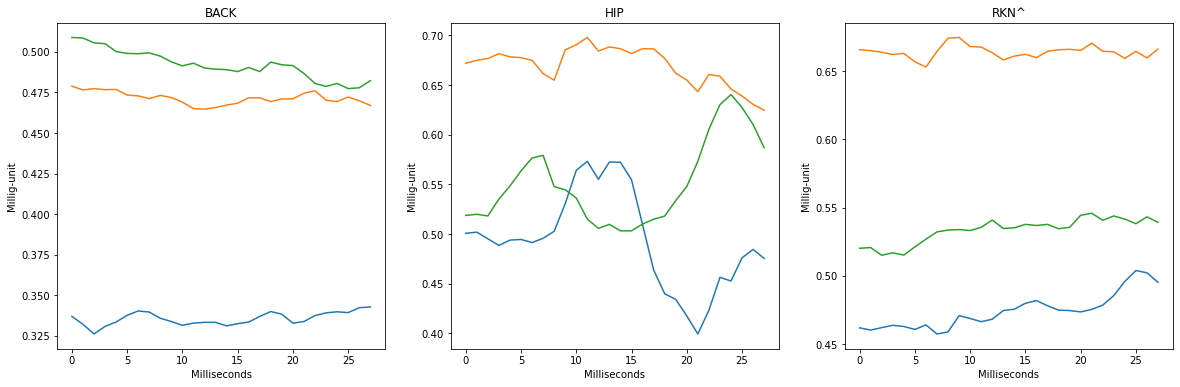

In [11]:
def column(matrix, i):
    return [row[i] for row in matrix]

def plot_sensor(ax, index, sensors, window_n, title, xlabel, ylabel):
    time = list(range(0, SLIDING_WINDOW_LENGTH))
    x = column(X_train[window_n], sensors[0])
    y = column(X_train[window_n], sensors[1])
    z = column(X_train[window_n], sensors[2])
    
    ax[index].plot(time, x, label="x-axis")
    ax[index].plot(time, y, label="y-axis")
    ax[index].plot(time, z, label="z-axis")
    ax[index].set(title=title, xlabel=xlabel, ylabel=ylabel)
    #ax[index].legend(loc="upper right")
    
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)
window_n = 0
plot_sensor(ax, 0, [36,37,38], window_n, "BACK", "Milliseconds", "Millig-unit")
plot_sensor(ax, 1, [0,1,2], window_n, "HIP", "Milliseconds", "Millig-unit")
plot_sensor(ax, 2, [3,4,5], window_n, "RKN^", "Milliseconds", "Millig-unit")
#fig.savefig('images/baseline+sw24_12+frame_' + str(window_n)) # number of classes, features, method
print("Class Label: "+ str(y_train[window_n]))


In [5]:
# flatten sliding window

def flatten_sliding_window(X_data):
    return X_data.reshape(X_data.shape[0], (X_data.shape[1] * X_data.shape[2]))

In [9]:
X_train = flatten_sliding_window(X_train)
X_test = flatten_sliding_window(X_test)

In [10]:
NUMBER_OF_CLUSTERS = 9

# time the cluster
start = time.time()

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(X_train).predict(X_test)
#y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(X_train, sample_weight=sample_weight_train).predict(X_test)

end = time.time()

print("Time:")
print(end - start)

Time:
78.2723798751831


In [11]:
uy_pred = y_pred.copy()
clusters = list(set(y_pred))
clusters.sort()

#relabels = brute_relabel(uy_pred, y_test)
relabels = greedy_relabel(uy_pred, y_test)
#relabels = [0, 2, 0, 0, 3, 1, 0, 2, 0, 3, 0]

uy_pred = relabel_list(uy_pred, clusters, relabels)
print_results(uy_pred, y_test, relabels)

Assigned Labels:
[1, 1, 0, 3, 1, 4, 0, 2, 2]

F1:
0.6071237262517181

Accuracy:
0.5980392156862745

ARI:
0.2859602392229483


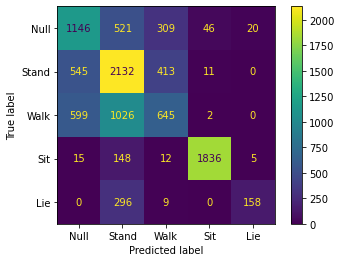

In [12]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, uy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot()

#plt.savefig('confusion_matricies/c4_f9(RLA)_km11.png') # number of classes, features, method
plt.show()